In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import stats
from scipy.spatial import distance

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools

import sys
sys.path.insert(1, '../') #make parent folder visible
from transformer import Transformer, create_masks, nopeak_mask

In [3]:
plt.style.use('ggplot')

In [4]:
checkpoint_dir = "../checkpoints/"

In [5]:
MAX_LEN = 256
MODEL_DIM = 512
N_LAYERS = 6

In [6]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)
TRANSFORMER_DEVICE = DEVICE #torch.device("cpu")

cuda


In [7]:
PRINTABLE_ASCII_CHARS = 95

_extra_chars = ["seq_start", "seq_end", "pad"]
EXTRA_CHARS = {key: chr(PRINTABLE_ASCII_CHARS + i) for i, key in enumerate(_extra_chars)}
ALPHABET_SIZE = PRINTABLE_ASCII_CHARS + len(EXTRA_CHARS)

In [8]:
def find_ckpts(*args, **kwargs):
    ckpts = os.listdir(checkpoint_dir)
    str_args = [str(x) for x in itertools.chain(args, kwargs.values())]
    return [checkpoint_dir + ckpt for ckpt in ckpts if all([arg in ckpt.replace(".", "_").split("_") for arg in str_args])]

In [9]:
def encode_char(c):
    return ord(c) - 32

def decode_char(n):
    return chr(n + 32)

In [10]:
def encode_string(string, start_char=chr(0)):
    return torch.tensor([ord(start_char)] + [encode_char(c) for c in string])

In [11]:
def pad_tensors(tensors, pad_char=chr(0), max_len=None):
    if not max_len:
        max_len = max([t.shape[0] for t in tensors]) + 1
        
    padded_tensors = torch.full((len(tensors), max_len), ord(pad_char), dtype=torch.long)
    for i, tensor in enumerate(tensors):
        padded_tensors[i, 0:tensor.shape[0]] = tensor
        
    return padded_tensors

# Load Transformer and Reacted Molecules

In [13]:
found = find_ckpts()
print(found)
load_path = found[0] if len(found) > 0 else ""

['../checkpoints/pretrained.ckpt']


In [14]:
model = Transformer(ALPHABET_SIZE, MODEL_DIM, N_LAYERS)
model = nn.DataParallel(model)
model = model.to(TRANSFORMER_DEVICE)

In [15]:
checkpoint = torch.load(load_path)
model.load_state_dict(checkpoint['state_dict'])
model = model.eval()

In [17]:
def criteria(file):
    if "_old" in file:
        return False
    if file.startswith('.'):
        return False
    return True

files = os.listdir('reactions/')
files = [file for file in files if criteria(file)]
print(files)

['neutralized_reactions.tsv', 'swap-fx_reactions-tests.csv', 'deletion_reactions.tsv', 'deletion_reactions-tests.csv', 'swap-fx_reactions.tsv', 'neutralized_reactions-tests.csv']


In [18]:
reactions = ['deletion_reactions.tsv', 
             'neutralized_reactions.tsv', 
             'swap-fx_reactions.tsv']

In [19]:
tests = ['deletion_reactions-tests.csv',
         'neutralized_reactions-tests.csv',
         'swap-fx_reactions-tests.csv']

In [20]:
filename = reactions[0]
with open("reactions/" + filename) as reaction:
    tokens = [line.strip("\n").split("\t") for line in reaction]
    print(len(tokens))
    num, original, product = ([x[i] for x in tokens] for i in range(3))

7180


In [21]:
clean_idxs = [i for i, p in enumerate(product) if '.' not in p]
print(len(clean_idxs))

1889


In [22]:
num = [num[i] for i in clean_idxs]
original = [original[i] for i in clean_idxs]
product = [product[i] for i in clean_idxs]

In [23]:
product

['Cc1ccc(Nc2ccc(CC(C)O)cc2)c([N+](=O)[O-])c1',
 'COc1ccc(OC)c2c(=O)cc(C)[nH]c12',
 'N#Cc1ccc(-c2ccc3c(c2)C2C=CN=C2C(=O)N3)cc1',
 'CCCCCC=CCC=CCCCCCCCCC(CCCCCCCCC=CCC=CCCCCC)OCCCN(C)CCCCCCN=[N+]=[N-]',
 'NCCCC1CCC1',
 'COc1cc(C)c(C(C)CN)c(C)c1',
 'CC(C)c1cc(-c2csc(CC=O)n2)ccc1OCc1ccccc1',
 'CCCOc1ccc(C2=CC(=O)N(c3ccc4ccccc4c3)C2c2ccc(Cl)c([N+](=O)[O-])c2)cc1OC',
 'O=c1[nH]c2cc(-c3ccno3)ccc2o1',
 'CCc1ccc(C(=O)c2ccccc2OC)cc1',
 'CCC1COC(C)CN1Cc1cccc(C)c1',
 'CC=CC=C(C)c1cc(C(C=CC)=CC)cc(-c2ccc(C3c4ccccc4-c4c(-c5ccccc5)cccc43)cc2)c1',
 'CCC1OC(=O)C=CC(C)C(OC2CC(N(C)C)CC(C)O2)C(CC=O)CC(C)C(=O)C=CC(C)=CC1COC1OC(C)C(OC(C)=O)C(OC)C1OC',
 'Cc1n[nH]c(C)c1NC(=O)C(C)(C)C=NO',
 'COc1cccc(N(C)CC2CCCC(C)(C)C2)c1',
 'O=C(NCCc1ccccc1)C1CCS(=O)(=O)C1',
 'CC(C)=C(F)Cn1cc(C)c(=O)[nH]c1=O',
 'C=CCOc1ccc(-c2cnc(C=CCCCCC)nc2)cc1F',
 'CCCCCc1ccccc1Oc1ccc(C(=O)NN2CCCCC2)cc1',
 'CCOc1cccc(F)c1',
 'Cc1ccc(C)c2c1SC(=CC(=O)OC(C)C)S2',
 'C=NC=NC(=C)C(Cc1ccccn1)C(=O)Nc1ccc(Cl)cc1',
 'O=C1C=C2N=CN=CC2C(C2(O)CC(O)C(C

# Calculate Change in Predicted Binding Confidence

[0.00000000e+00 1.76855615e-08] [1.00000000e+00 4.50107683e-18] [1.00000000e+00 1.76855615e-08]
1889


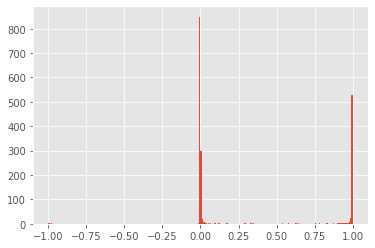

In [24]:
filename = tests[0]
with open("reactions/" + filename) as test:
    lines = test.readlines()
    
smiles = lines[0].strip("\n").strip("['").strip("']").split("'] ['")
scores = lines[1].strip("\n").strip('"[').strip(']"').split(']" "[')
scores = np.array([list(map(float, [num for num in x.split(' ') if len(num) > 0])) for x in scores])

products = lines[2].strip("\n").replace('"', "'").strip("'[''['").strip("']'']'").split("']'']' '[''['")
scores_prod = lines[3].strip("\n").strip('"[').strip(']"').split(']" "[')
scores_prod = np.array([list(map(float, [num for num in x.split(' ') if len(num) > 0])) for x in scores_prod])

scores_diff = lines[4].strip("\n").strip('"[').strip(']"').split(']" "[')
scores_diff = np.array([list(map(float, [num for num in x.split(' ') if len(num) > 0])) for x in scores_diff])

i = 10
print(scores_diff[i], scores_prod[i], scores[i])

clean_idxs = [i for i, p in enumerate(products) if '.' not in p]
print(len(clean_idxs))

scores_diff = scores_diff[clean_idxs,1]
scores_prod = scores_prod[clean_idxs,1]
scores = scores[clean_idxs,1]
smiles = [smiles[i] for i in clean_idxs]
products = [products[i] for i in clean_idxs]

plt.hist(scores_diff, bins=250)
plt.show()

In [25]:
diff_rank = np.array([stats.percentileofscore(scores_diff, score) for score in scores_diff])
print(diff_rank)
prod_rank = np.array([stats.percentileofscore(scores_prod, score) for score in scores_prod])
orig_rank = np.array([stats.percentileofscore(scores, score) for score in scores])

[26.5219693  24.4044468  59.52885124 ... 96.00317628 82.47750132
 87.7977766 ]


# Embed Molecules

In [26]:
def embed(smiles):
    with torch.no_grad():
        encoded = encode_string(smiles, start_char=EXTRA_CHARS['seq_start']).unsqueeze(0).to(TRANSFORMER_DEVICE)
        encoded = encoded[:,:MAX_LEN]
        mask = create_masks(encoded)
        embedding = model.module.encoder(encoded, mask)[0].cpu()
    return embedding

In [27]:
original_embeddings = []
product_embeddings = np

In [28]:
max_len = max(max(list(map(len, smiles))), max(list(map(len, products))))
max_len

197

In [29]:
similarities = []
distances = []
for i in range(len(smiles)):
    with torch.no_grad():
        embedding_pad = torch.zeros((max_len+1, 512))
        #print(len(smiles[i]), smiles[i])
        embedding = embed(smiles[i])
        embedding_pad[:embedding.shape[0],:] = embedding 
        #print(embedding_pad.shape)

        embedding_prod_pad = torch.zeros((max_len+1, 512))
        #print(len(products[i]), products[i])
        embedding_prod = embed(products[i])
        embedding_prod_pad[:embedding_prod.shape[0],:] = embedding_prod
        #print(embedding_prod_pad.shape)

    sim = F.cosine_similarity(embedding_prod_pad.view(1, -1), embedding_pad.view(1, -1))
    dist = (embedding_prod_pad - embedding_pad).sum()
    similarities.append(sim.item())
    distances.append(dist.item())
similarities = np.array(similarities)
distances = np.array(distances)

In [30]:
embeddings = torch.zeros((2, len(smiles), max_len+1, 512))
for i in range(len(smiles)):
    with torch.no_grad():
        #print(len(smiles[i]), smiles[i])
        embedding = embed(smiles[i])
        embeddings[0,i,:embedding.shape[0],:] = embedding 
        #print(embedding_pad.shape)

        embedding_prod_pad = torch.zeros((max_len+1, 512))
        #print(len(products[i]), products[i])
        embedding_prod = embed(products[i])
        embeddings[1,i,:embedding_prod.shape[0],:] = embedding_prod
        #print(embedding_prod_pad.shape)

print(embeddings.shape)

torch.Size([2, 1889, 198, 512])


# Calculate Distance in Embedding Space

In [31]:
embedding_diffs = embeddings[1] - embeddings[0]

In [32]:
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap, Normalize
import matplotlib.pyplot as plt

In [33]:
pca = PCA(n_components=2)
pca.fit(embeddings[0].view(embeddings.shape[1],embeddings.shape[2]*512).cpu().numpy())
p = pca.transform(embeddings.view(2*embeddings.shape[1],embeddings.shape[2]*512).cpu().numpy())

In [34]:
p = p.reshape(2, embeddings.shape[1], -1)
print(p.shape)

(2, 1889, 2)


In [36]:
p_diffs = p[1] - p[0]
p_diffs.shape

(1889, 2)

# Plot

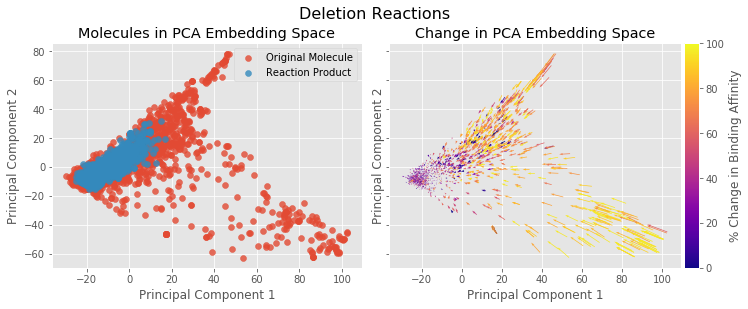

In [38]:
plt.rcParams["figure.figsize"] = (12, 4)
plt.rcParams["figure.figsize"] = (3.5 * 3, 1.375 * 3)

idx1, idx2 = 0, 1

fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True, squeeze=True)

cmap = plt.get_cmap('plasma')
colors = [cmap(rank/100) for rank in diff_rank]
#for i in range(230):
#    ax[0].plot(p[:,i,0], p[:,i,1], c=colors[i], alpha=0.4 * diff_rank[i]/100)
#plt.quiver(p[1,:,idx1], p[1,:,idx2], v, u, color=colors)

ax[0].scatter(p[0,:,idx1], p[0,:,idx2], alpha=0.8, label='Original Molecule')
ax[0].scatter(p[1,:,idx1], p[1,:,idx2], alpha=0.8, label='Reaction Product')
ax[0].legend(loc='upper right')

import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax[1])
ax_cb = divider.new_horizontal(size="5%", pad=0.05)
cb1 = matplotlib.colorbar.ColorbarBase(ax_cb, norm=matplotlib.colors.Normalize(vmin=0.0, vmax=100.0), cmap=matplotlib.cm.plasma, orientation='vertical')
cb1.set_label("% Change in Binding Affinity")
plt.gcf().add_axes(ax_cb)

#plt.scatter(p[0,:,0], p[0,:,1])

cmap = plt.get_cmap('plasma')
colors = [cmap(rank/100) for rank in diff_rank]
#colors = [(r/100, g/100, b/100) for r, g, b in zip(orig_rank, prod_rank, diff_rank)]

#plt.scatter(p[1,:,idx1], p[1,:,idx2], c=colors, alpha=0.2)
#for i in range(230):
#    plt.plot(p[:,i,0], p[:,i,1], c='gray', alpha=0.05)
ax[1].quiver(p[0,:,idx1], p[0,:,idx2], p_diffs[:,idx1], p_diffs[:,idx2], color=colors, units='xy')
#plt.quiver(p[1,:,idx1], p[1,:,idx2], v, u, color=colors, units='xy')

suptitle = plt.suptitle("Deletion Reactions", fontsize=16, y=1.03)
ax[0].set_title("Molecules in PCA Embedding Space")
ax[1].set_title("Change in PCA Embedding Space")

ax[0].set_xlabel("Principal Component 1")
ax[0].set_ylabel("Principal Component 2")
ax[1].set_xlabel("Principal Component 1")
ax[1].set_ylabel("Principal Component 2")

plt.tight_layout()
#fig.tight_layout(rect=[0, 0.03, 1, 0.95])

#plt.savefig('result_figures/deletion_embedding_toc.png', dpi=300, bbox_inches="tight", bbox_extra_artists=(suptitle,))

plt.show()